In [1]:
import os
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
import scipy.misc as smp
from PIL import Image
import numba
from numba import njit, vectorize, cuda
from timeit import default_timer as timer
from pylab import imshow, show
from tqdm import tqdm
import math

In [15]:
resolution = (1280,720)
J_c = (0,0)
J_z = 1

const = complex(0.835, -0.2321)
R = 1000

@njit
def Mandelbrot(x, y, max_iterations):
    c = complex(x,y)
    dz = complex (0,0)
    z = 0.0j
    for iterations in range(max_iterations):
        dz = dz*2*z +1
        z = z*z + c
        if (z.real*z.real + z.imag*z.imag) >= (R*R):
            break
    distance = (abs(dz))*(abs(z)*math.log(abs(z)))
    return distance

mandel_gpu = cuda.jit(device=True)(Mandelbrot)

@cuda.jit
def render_kernel(centre_x, centre_y, zoom, max_iter, rendergrid):
    xmin = centre_x - (3.5/(2*zoom))
    xmax = centre_x + (3.5/(2*zoom))
    ymin = centre_y - (2/(2*zoom))
    ymax = centre_y + (2/(2*zoom))

    pixel_width = (xmax-xmin)/resolution[0]
    pixel_height = (ymax-ymin)/resolution[1]
    
    startX, startY = cuda.grid(2)
    gridX = cuda.gridDim.x * cuda.blockDim.x
    gridY = cuda.gridDim.y * cuda.blockDim.y

    for i in range(startX, resolution[0], gridX):
        real = xmin + i*pixel_width
        for j in range(startY, resolution[1], gridY):
            imaginary = ymin + j*pixel_height
            colour = mandel_gpu(real,imaginary, max_iter)
            rendergrid[j,i] = math.log(colour)/0.6931471805599453

In [16]:
frames = []
total_framecount = 1
cm = plt.get_cmap('rainbow')

for i in tqdm(range(total_framecount)):
    a = complex(0,(i*2*np.pi/total_framecount))
    const = 0.7885*np.exp(a)
    grendergrid = np.zeros((resolution[1], resolution[0]), dtype = np.uint8)
    d_rendergrid = cuda.to_device(grendergrid)
    render_kernel[griddim, blockdim](const.real, const.imag, 1, 10000, d_rendergrid) 
    d_rendergrid.to_host()
    #Image.fromarray( grendergrid ).save(str(i)+' julia.png')
    colored = cm( grendergrid )
    Image.fromarray((colored[:, :, :3] * 255).astype(np.uint8)).save(str(i)+' julia.png')# Create a PIL image
    #frames.append(img)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.18s/it]


Julia created on GPU in 0.457587 s


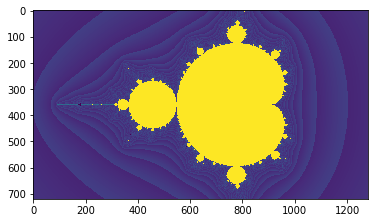

In [8]:
grendergrid = np.zeros((resolution[1], resolution[0]), dtype = np.uint8)
blockdim = (32,8)
griddim = (32,16)

start = timer()
d_rendergrid = cuda.to_device(grendergrid)
render_kernel[griddim, blockdim](-0.5, 0, 1, 1000, d_rendergrid) 
d_rendergrid.to_host()
dt = timer() - start

print("Julia created on GPU in %f s" % dt)

imshow(grendergrid)
show()

In [ ]:
frames[0].save('Greyscale_Zoom.gif', format='GIF', append_images=frames[1:], save_all=True, duration=175, loop=0, quality=20, optimize=True)

In [61]:
np.log(2)

0.6931471805599453